# 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sys

sys.path.insert(0, '/home/storage2/hans/jax_reco/python')
from network import TriplePandleNet
from trafos import transform_dimensions, transform_dimensions_vec, transform_network_outputs
from plotting_tools import adjust_plot_1d

import jax
import jax.numpy as jnp

In [3]:
# load network
net = TriplePandleNet('../../data/network/')

2024-05-09 17:24:35.068618: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(1000, 20)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


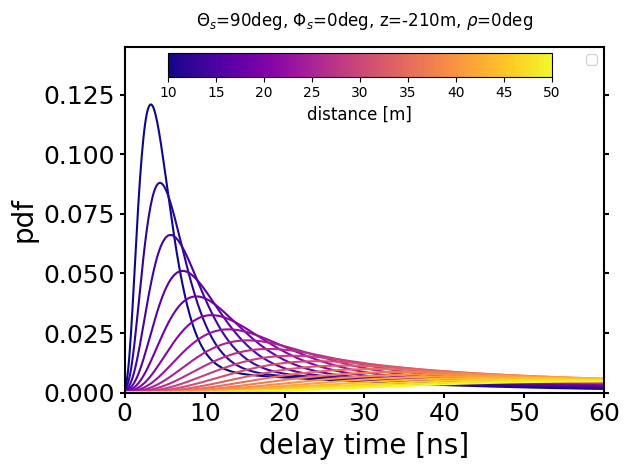

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

# make 20 plots of the distributions
n = 20
cmap = plt.cm.plasma
cols = cmap(np.linspace(0.0, 1.0, n))
dists = np.linspace(10, 50, n).reshape(20, 1)

# stitch together a tensor with coordinates
rho = 0.0 * np.ones_like(dists)
z = -210 * np.ones_like(dists)
zenith = 90 * np.ones_like(dists)
azimuth = 0.0 * np.ones_like(dists)
x = jnp.concatenate([dists, rho, z, zenith, azimuth], axis=1)

# transform tensor to units and coordinates used by network
x = transform_dimensions_vec(x)

# apply network and transform output
y_pred = net.eval_on_batch(x)
logits, a, b = transform_network_outputs(y_pred)

# create a batch of mixture distributions
gm = tfd.MixtureSameFamily(
          mixture_distribution=tfd.Categorical(
              logits=logits
              ),
          components_distribution=tfd.Gamma(
            concentration=a,    
            rate=b,
            force_probs_to_zero_outside_support=True
              )
    )

# vectorized plotting
xvals = np.linspace(-10, 100, 1000)
xvals = np.repeat(xvals[np.newaxis,:], 20, axis=0).T
print(xvals.shape)

yvals = gm.prob(xvals)

fig, ax = plt.subplots()
ax.set_prop_cycle(color=cols)
plt.plot(xvals, yvals)

plot_args = {'xlim':[0, 60],
                 'ylim':[0.0, 1.2 * np.amax(yvals)],
                 'xlabel':'delay time [ns]',
                 'ylabel':'pdf'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"$\\Theta_s$={zenith[0 ,0]:.0f}deg, $\\Phi_s$={azimuth[0 ,0]:.0f}deg, z={z[0 ,0]:.0f}m, $\\rho$={rho[0 ,0]:.0f}deg", pad=15)
plt.tight_layout()
cax = fig.add_axes([0.27, 0.83, 0.6, 0.05])
cb = fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(vmin=dists[0, 0], vmax=dists[-1, 0]),
                                       cmap=cmap), cax=cax, orientation='horizontal')
cb.set_label('distance [m]',fontsize=12)
plt.show()